# TipTop — Papyrus Tutorial

**Objective:** Build a TipTop parameter file for the *Papyrus* system, verify key optical/AO quantities, and run PSF simulations.

> This notebook is organized in short steps with **TODO** cells for you to complete.

## Prerequisites

- Python 3.11+ recommended
- Packages: `tiptop v.1.3.29`, `astropy`, `matplotlib`, `numpy`
- Basic knowledge: r₀, seeing, λ/D, SR, FWHM.
- **Papyrus base INI file** (starter parameter set) — download [here](https://astro-tiptop-services.github.io/astro-tiptop-services/resources/AO_school)


## Notebook structure
1. Overview of required parameter file sections.
2. Create a `papyrus.ini` skeleton 👉 Complete the TODOs.
3. Quick exercise: diffraction-limited resolution.
4. Run TipTop with Papyrus parameters.
5. Error Budget Mini-Exercises

---


## 1) Minimum Required Sections

Regardless of the AO architecture, every configuration starts with the **telescope** and the **atmosphere**.

### Always required
- **`[telescope]`**  
  - `TelescopeDiameter` *(m)*
  - Optional: `Resolution` *(pixels across the pupil)*, `ObscurationRatio`, `ZenithAngle`
- **`[atmosphere]`**  
  - Provide **either** `Seeing` *(arcsec)* **or** `r0_Value` (m)  
  - Optional: `Wavelength` (reference λ for the above, default _@500nm_), `L0`, `Cn2Weights`, `Cn2Heights`, `WindSpeed`,`WindDirection`

- **`[sources_science]`** *(your science target)*  
  - `Wavelength` (scalar or list in meters)  
  - Optional: `Zenith`, `Azimuth` (default 0 if omitted)

- **`[sensor_science]`** *(image formation / detector sampling)*  
  - `PixelScale` *(mas/pixel)*  
  - `FieldOfView` *(pixel/spaxel)*

### AO modules (conditional)
**High-Order (HO) with a Natural Guide Star (NGS) — SCAO**  
  If you use a single NGS for wavefront sensing:
  - **`[sources_HO]`** (the guide star properties; typically wavelength/position)
  - **`[sensor_HO]`** (the WFS configuration; e.g., `WfsType='pyramid'`, `NumberPhotons`, `SigmaRON`, etc.)
  - **`[DM]`** (deformable mirror geometry; e.g., `NumberActuators`, `DmPitchs`, `DmHeights`)
  - **`[RTC]`** (control loop; e.g., `LoopGain_HO`, `SensorFrameRate_HO`, `LoopDelaySteps_HO`)

> **Rule of thumb:** if you define any `sources_*` block for sensing, you **must** also define the matching `sensor_*` block (and vice-versa).

---

### Minimal SCAO (NGS) checklist
- `[telescope]` with `TelescopeDiameter` 
- `[atmosphere]` with **either** `Seeing` **or** `r0_Value` 
- `[sources_science]` with your science `Wavelength`(s)  
- `[sensor_science]` with `PixelScale`  
- `[sources_HO]` **and** `[sensor_HO]` (NGS + WFS settings)  
- `[DM]` (actuator layout)  
- `[RTC]` (loop gain, frame rate, delay)

---


## 2) Skeleton `papyrus.ini` file
👉 [Dowload it](https://astro-tiptop-services.github.io/astro-tiptop-services/resources/AO_school) and Open it and fill the `TODO`.

💡**Need help?**  
- TIPTOP How to set up: https://astro-tiptop-services.github.io/astro-tiptop-services/docs/orion/howtosetup  
- Parameter files reference: https://astro-tiptop-services.github.io/astro-tiptop-services/docs/orion/parameterfiles

## 3) Exercise — Diffraction-limited Resolution 

Compute the diffraction-limited FWHM (approx. in arcseconds) for:

- the NGS/HO at 790 nm (I-band)
- the science object at 2179 nm (K-band)

_Indicative formula for an unobstructed circular pupil: `θ≈1.03λ/D` (in radians) → convert to arcseconds._

Given your detector pixel scale (mas/pixel), does it satisfy the Nyquist criterion at both wavelengths? <br/>
_(Hint: Nyquist requires ≥2 pixels per FWHM; i.e. pixel scale ≤ FWHM/2)._

In [1]:

import numpy as np

# Set your telescope diameter in meters
D = 1.52 # 👈

lambda_ngs = 790e-9      # @790 nm # I band
lambda_src = 2.179e-6    # @2179 nm # K band

K = 1.03 * 206265  # rad -> arcsec with 1.22*lambda/D

theta_ngs_arcsec = K * lambda_ngs / D
theta_src_arcsec = K * lambda_src / D

print(f"Diffraction-limited FWHM @790 nm:  {theta_ngs_arcsec:.6f} arcsec ({theta_ngs_arcsec*1e3:.2f} mas)")
print(f"Diffraction-limited FWHM @2179 nm: {theta_src_arcsec:.6f} arcsec ({theta_src_arcsec*1e3:.2f} mas)")


Diffraction-limited FWHM @790 nm:  0.110420 arcsec (110.42 mas)
Diffraction-limited FWHM @2179 nm: 0.304562 arcsec (304.56 mas)


## 4) Run TipTop with PAPYRUS parameters




### A) Imports

In [2]:
from tiptop.tiptop import *
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
import numpy as np

Cupy import successfull. Installed version is: 13.4.1
Cupy import successfull. Installed version is: 13.4.1
Cupy import successfull. Installed version is: 13.4.1


### B) Define paths and filenames

- `path_in` : folder containing your `.ini` parameter file
- `path_out` : output folder (must exist or be creatable)
- `file_in` : base name (without extension) of the `.ini` file
- `file_out` : prefix for output files

In [3]:
# %% Path configuration 
path_in = './'            # 👈 adapt to your setup
path_out = './'          # 👈 adapt to your setup
file_in = "papyrus_IR"       # without .ini extension
file_out = "papyrus_IR"  # output prefix

# Create output folder if needed
os.makedirs(path_out, exist_ok=True)

print("path_in :", path_in)
print("path_out:", path_out)
print("file_in :", file_in)
print("file_out:", file_out)

path_in : ./
path_out: ./
file_in : papyrus_IR
file_out: papyrus_IR


### C) Run TIPTOP simulation

`tiptop.overallSimulation` runs a complete TipTop simulation based on an input parameter file. The function accepts several optional arguments to enable or disable specific features and select desired outputs.
Click [here](https://astro-tiptop-services.github.io/astro-tiptop-services/docs/orion/howtosetuplaunchfile#overallSimulation) to access to the overallSimulation function documentation.

In [4]:
overallSimulation(path_in, file_in, path_out, file_out, verbose=True, getHoErrorBreakDown=True)
print("✅ Simulation complete")

LO part is not present
******** HO PSD science and NGSs directions
extra error in nm RMS:  0
extra error spatial frequency exponent:  -2
extra error in nm RMS (LO):  0
extra error spatial frequency exponent (LO):  -2

_____ ERROR BREAKDOWN  ON-AXIS_____
------------------------------------------
.Maréchal Strehl at 2.18micron:	83.31%
.Residual wavefront error:	148.21nm
.NCPA residual:			0.00nm
.Fitting error:			80.53nm
.Differential refraction:	0.00nm
.Chromatic error:		13.80nm
.Aliasing error:		0.37nm
.Noise error:			59.04nm
.Spatio-temporal error:		108.65nm
.Wind-shake error:		0.00nm
.Additionnal jitter:		0.00mas / 0.00nm
.Extra error:			0.00nm
-------------------------------------------
.Sole servoLag error:		108.65nm
.Sole reconstruction error:	0.00nm
-------------------------------------------
.Sole anisoplanatism error:	0.00nm
-------------------------------------------
Required time for total calculation (ms)	 : 117.856741
Required time for AO system model init (ms)	 : 3.000736


### D) Open the output FITS and extract data

We extract:
- **AO-corrected PSF** (HDU 1)
- **Seeing-limited PSF** (HDU 2)
- **Diffraction-limited PSF** (HDU 3)
- **Radial profiles** (HDU 4 or 5 depending on save options)
- Useful metadata from the FITS header (wavelength, pixel scale, Strehl, FWHM)

Click [here](https://astro-tiptop-services.github.io/astro-tiptop-services/docs/orion/howtosetuplaunchfile#simulation_output) to the simulation output documentation.


In [5]:
# %% Open FITS file
fits_path = os.path.join(path_out, file_out + ".fits")
print("Reading:", fits_path)

ao = aoSystem(f"{path_in}{file_in}.ini")

with fits.open(fits_path) as hdul:
    hdul.info()

    psf_ao   = hdul[1].data[0, ...]  # AO-corrected
    psf_turb = hdul[2].data          # seeing-limited
    psf_dl   = hdul[3].data          # diffraction-limited

    # Profiles (HDU 4 or 5 depending on CONTENT)
    header4 = hdul[4].header
    if header4.get('CONTENT') == 'Final PSFs profiles':
        profiles = hdul[4].data
    else:
        profiles = hdul[5].data

    # Metadata
    psf_header = hdul[1].header
    wvl = float(psf_header.get("WL_NM"))        # wavelength (nm)
    pix_mas = float(psf_header.get("PIX_MAS"))  # pixel scale (mas)

    # ✅ corrected from original script:
    sr_key   = f"SR{0:04d}"
    fwhm_key = f"FWHM{0:04d}"
    sr   = psf_header.get(sr_key)    # Strehl ratio
    fwhm = psf_header.get(fwhm_key)  # FWHM (mas)
    hdul.close()

print("Pixel scale [mas]:", pix_mas)
print("Strehl Ratio:", sr)
print("FWHM [mas]:", fwhm)
print("Wvl [nm]:", wvl)

Reading: ./papyrus_IR.fits
Filename: ./papyrus_IR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1                1 ImageHDU        21   (512, 512, 1)   float64   
  2                1 ImageHDU        10   (512, 512)   float64   
  3                1 ImageHDU        10   (512, 512)   float64   
  4                1 ImageHDU        11   (256, 1, 2)   float64   
Pixel scale [mas]: 76.6
Strehl Ratio: 0.64106
FWHM [mas]: 326.605
Wvl [nm]: 2179.0


### E) Normalize PSFs and build axis in arcseconds

In [6]:
# %% Normalize
psf_ao   = psf_ao / np.sum(psf_ao)
psf_dl   = psf_dl / np.sum(psf_dl)
psf_turb = psf_turb / np.sum(psf_turb)

# Axis in arcsec
nx = psf_ao.shape[0]
axis = np.linspace(-nx//2, nx//2, nx) * pix_mas * 1e-3  # mas -> arcsec

crop_size = 4
nx = FourierUtils.cropSupport(psf_ao, crop_size).shape[0]
axis = np.linspace(-nx//2, nx//2, nx) * pix_mas * 1e-3

### F) Visualize PSFs (log scale)

We adjust the dynamic range to display down to $10^{-5}$ of the maximum.


In [7]:
# %% Plot PSFs
def plot_psf(psf, title, position):
    plt.subplot(1, 3, position)
    im = plt.imshow(psf, norm=norm, cmap='Spectral_r',
                    extent=[axis[0], axis[-1], axis[0], axis[-1]])
    plt.title(title, pad=10)
    plt.xlabel('[arcsec]')
    if position == 1:
        plt.ylabel('[arcsec]')
    else:
        plt.ylabel('')
    plt.colorbar(im, fraction=0.046)

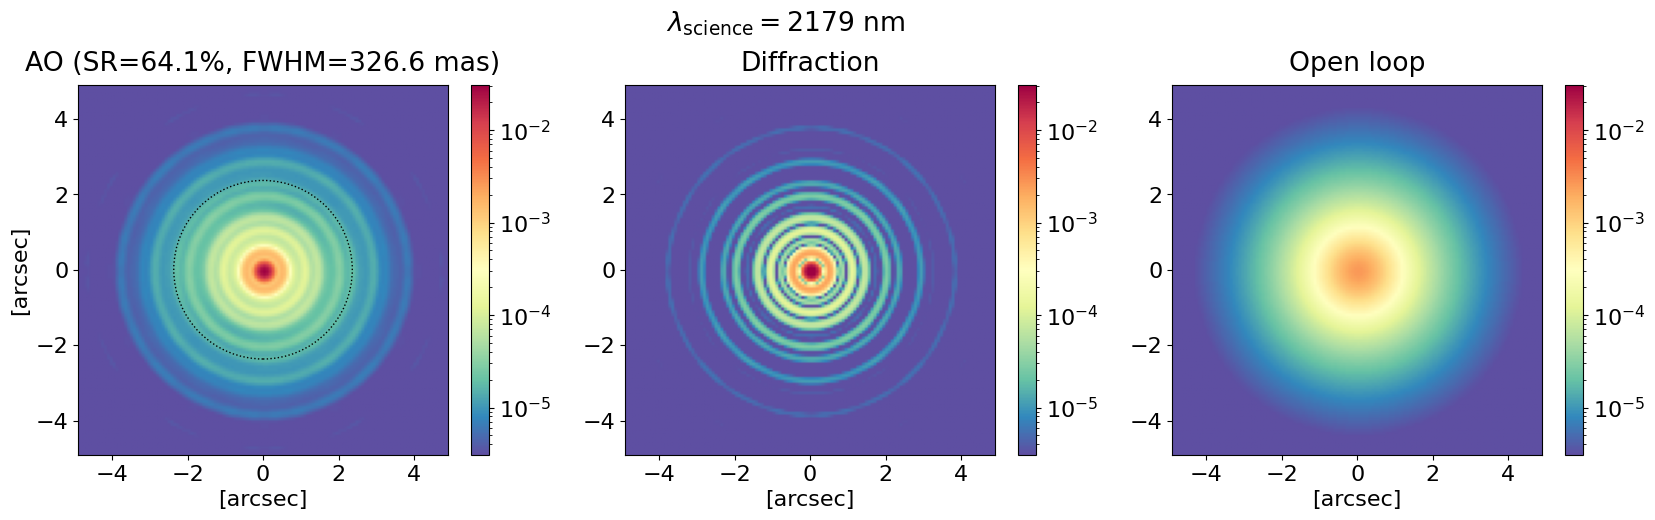

In [8]:
psf_max = psf_ao.max()
vmax = psf_max
vmin = psf_max * 1e-4
norm = LogNorm(vmin=vmin, vmax=vmax)
rad2arcsec = 206265
control_radius = ao.src.wvl/ao.tel.D*ao.dms.nActu1D[0]/2*rad2arcsec

plt.figure(1, figsize=(20, 5))
plt.suptitle(rf'$\lambda_{{\mathrm{{science}}}} = {int(wvl)}$ nm', y=1)
plt.subplots_adjust(top=0.85)
plot_psf(FourierUtils.cropSupport(psf_ao, crop_size),  f'AO (SR={sr*100:.1f}%, FWHM={fwhm:.1f} mas)', 1)
corr_zone = Circle([0,0], control_radius, fc='none', ec='k', ls=':')
plt.gca().add_artist(corr_zone)
plot_psf(FourierUtils.cropSupport(psf_dl, crop_size),  'Diffraction', 2)
plot_psf(FourierUtils.cropSupport(psf_turb, crop_size),'Open loop', 3)
plt.show()

### G) Radial Profile (AO PSF) 

In [9]:
# Radial profile
radii = profiles[0, 0, :]*1e-3
p_norm = profiles[1, 0, :] / np.max(profiles[1, 0, :])

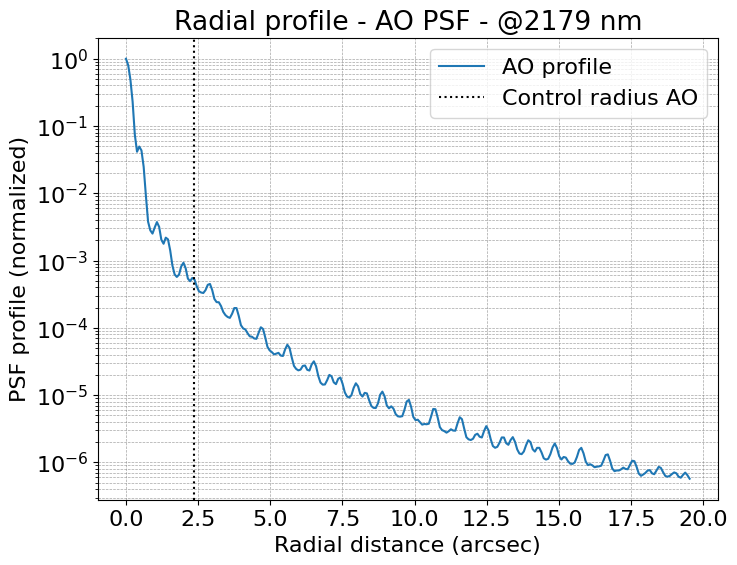

In [10]:
# Plots
plt.figure(figsize=(8, 6))
plt.title('PSF')
plt.semilogy(radii, p_norm, label='AO profile')
plt.axvline(control_radius, c='k', ls=':', label='Control radius AO')
plt.xlabel('Radial distance (arcsec)')
plt.ylabel('PSF profile (normalized)')
plt.title(f'Radial profile - AO PSF - @{int(wvl)} nm')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.show()

## 5) Error Budget Mini-Exercises 

These exercises explore the main contributions to the Adaptive Optics **error budget**: 
- Temporal error (servo-lag)  
- Measurement noise (photon flux / WFS RON)  
- Fitting error (DM actuator sampling)  
- Atmospheric effects (seeing, wind speed)

**Goal.** Explore how key parameters impact AO error terms and delivered image quality.

---

### Baseline
Start from your **Papyrus baseline configuration**:  
- Same seeing (r0), wind speed, telescope diameter, pixel scale, DM geometry.  
- Keep everything fixed **except** the parameter under test.

---

### 1) **Temporal error**  

> **Vary:** loop frame rate `RTC.FrameRate_HO`.  

**Record:**
- From TipTop’s error breakdown: **Spatio-temporal error** (nm RMS).
- Overall **Strehl** and **FWHM**

**Plot**
- Strehl **vs** frame rate. 
- FWHM **vs** frame rate.

>  ✍️ *What is the expected trend?*

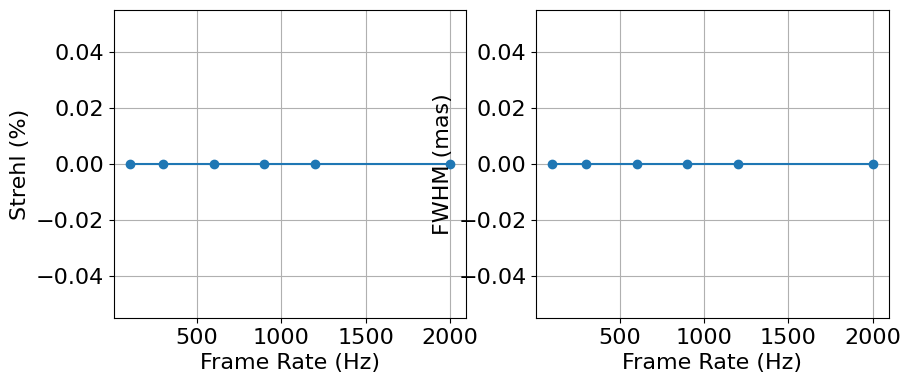

In [13]:
# Example test values (Hz)
Frame_Rate = np.array([100, 300, 600, 900, 1200, 2000])

# TODO: replace with your simulation results
Strehl = np.array([0., 0., 0., 0., 0., 0.])*100
FWHM   = np.array([0., 0., 0., 0., 0., 0.])   

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Frame_Rate, Strehl, 'o-')
plt.xlabel("Frame Rate (Hz)")
plt.ylabel("Strehl (%)")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Frame_Rate, FWHM, 'o-')
plt.xlabel("Frame Rate (Hz)")
plt.ylabel("FWHM (mas)")
plt.grid(True)
plt.show()


**About the loop gain (optional):**  
- Increasing **Loop Gain** enlarges the effective bandwidth → reduces servo-lag.  
- Too low → under-correction.  
- Too high → noise amplification / instability.  
- Try sweeping `RTC.LoopGain_HO` between 0.2 and 0.8 (e.g. at 600 Hz).

### 2) **Measurement noise** 
- **Vary:** photon flux (`sensor_HO.NumberPhotons`) (or NGS magnitude) 
- *(Optional)* also vary WFS RON (`sensor_HO.SigmaRON`).  
 
**Record:**  
- From TipTop’s error breakdown: *Noise error* (nm RMS).  
- Overall Strehl.

**Plot:**  
- Strehl vs photons (at fixed RON).  
- *(Optional)* Strehl vs RON (at fixed photons). 

> ✍️ *What is the expected trend?*  

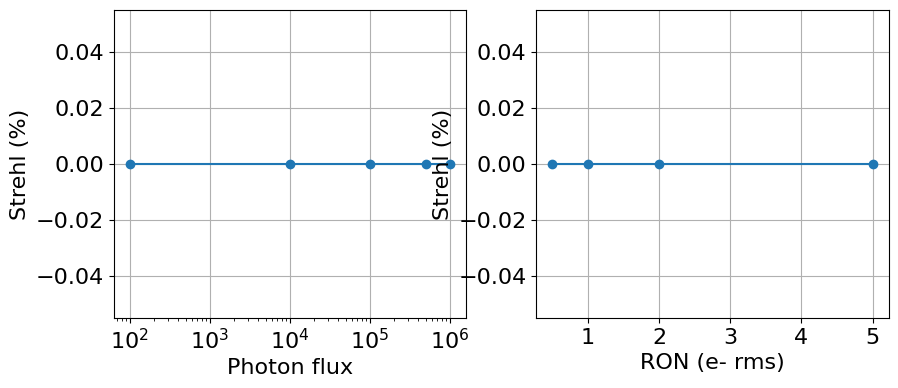

In [14]:
Photons = np.array([1e2, 1e4, 1e5, 5e5, 1e6])  # TODO
RON     = np.array([0.5, 1.0, 2.0, 5.0])       # TODO

# TODO: fill with simulation results
Strehl_vs_Photons = np.zeros_like(Photons)
Strehl_vs_RON     = np.zeros_like(RON)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogx(Photons, Strehl_vs_Photons, 'o-')
plt.xlabel("Photon flux")
plt.ylabel("Strehl (%)")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(RON, Strehl_vs_RON, 'o-')
plt.xlabel("RON (e- rms)")
plt.ylabel("Strehl (%)")
plt.grid(True)
plt.show()

### 3) **Fitting error** 
- **Vary:** number of DM actuators across the pupil (`DM.NumberActuators`, e.g. 20, 30, 40, 56).  

**Record:**  
- From TipTop’s error breakdown: *Fitting error* (nm RMS).  
- Overall Strehl.  

**Plot:**  
- Strehl vs number of actuators.  

**Reminder:**  
- The DM cut-off spatial frequency is approximately:  

  $
  f_\mathrm{c} \approx \frac{N_\mathrm{actu}}{2 \, D} (\text{cycles/m})
  $ 

  where $N_\mathrm{actu}$ is the number of actuators across the pupil diameter $D$.  
- Increasing actuator density increases the DM cut-off frequency, improving correction of higher spatial frequencies.  

> ✍️ *How does actuator density impact fitting error?*  


In [ ]:
nActu = np.array([20, 30, 40, 56])

# TODO: simulation results
Strehl_vs_Actu = np.zeros_like(nActu, dtype=float)

plt.figure()
plt.plot(nActu, Strehl_vs_Actu, 'o-')
plt.xlabel("DM actuators across pupil")
plt.ylabel("Strehl (%)")
plt.grid(True)
plt.show()

### 4) **Atmospheric effects** (seeing and wind)

- **Vary:** seeing (`Seeing` or `r0_Value`) and *(Optional)* wind speed.  

**Record:**  
- Overall Strehl.  

**Plot:**  
- Strehl vs r0.
- *(Optional)* Strehl vs wind.  

> ✍️ *How do atmospheric conditions shape the AO error budget?* 

<!-- 
- *Expected:*  
  - Larger r0 (better seeing) → higher Strehl  
  - Stronger wind (shorter τ0) → worse temporal error   -->

<!-- **Optional diagnostics**
- Draw the **control radius** on the MTF (cycles/aperture or mas) and compare with trends above.
- If available, save/inspect **phase PSD** to see which band (low/med/high f) is most impacted. -->

In [ ]:
r0_values   = np.array([0.1, 0.15, 0.2, 0.3])   # in m
wind_speeds = np.array([5, 10, 20, 30])        # in m/s

# TODO: simulation results
Strehl_vs_r0   = np.zeros_like(r0_values)
Strehl_vs_wind = np.zeros_like(wind_speeds)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(r0_values, Strehl_vs_r0, 'o-')
plt.xlabel("r0 (m @ 500nm)")
plt.ylabel("Strehl (%)")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(wind_speeds, Strehl_vs_wind, 'o-')
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Strehl (%)")
plt.grid(True)
plt.show()

**Reminder:**  
- Larger r0 → weaker turbulence (better seeing).  
- Wind speed defines the atmospheric coherence time:  

  $
  \tau_0 \approx 0.31 \, \frac{r_0}{v_\mathrm{wind}}
 $

  Shorter $\tau_0$ (stronger wind or poor seeing) makes temporal error worse.
